NLP Task : Twitter Sentient Analysis


note: Change your runtime to GPU if you are using google colab

# NLP Sentient analysis with Custom Vocabulary and Embeddings

In [5]:
# @title Imports
from IPython.display import clear_output
from google.colab import files
from glob import glob as g
import json
import tensorflow as tf
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
!pip install --upgrade kaggle
clear_output()

## Loading Twitter Comments from kaggle

In [6]:
# @title Opening Kaggle.json by uploading 


# kaggle.json contains the need user account to access kaggle and download the dataset
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

print("Downloading Dataset from kaggle")
!kaggle datasets download -d kazanova/sentiment140
print("Unzipping the dataset")
!unzip -qx /content/sentiment140.zip
print("Dataset Extracted")

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes
 74% 60.0M/80.9M [00:00<00:00, 161MB/s]
100% 80.9M/80.9M [00:00<00:00, 173MB/s]
Unzipping the dataset
Dataset Extracted


## Making The Dataframe

In [7]:
columns = ['target', 'ids', 'date', 'flag' ,'user', 'text']
data_path = '/content/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(data_path,names = columns , encoding='latin-1')
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df['target'].unique()

array([0, 4])

In [9]:
df[df['target'] == 4 ][:1]

,target,ids,date,flag,user,text
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!


In [10]:
df['target'].unique()

array([0, 4])

In [11]:
df.iloc[-1]

target                                                    4
ids                                              2193602129
date                           Tue Jun 16 08:40:50 PDT 2009
flag                                               NO_QUERY
user                                         RyanTrevMorris
text      happy #charitytuesday @theNSPCC @SparksCharity...
Name: 1599999, dtype: object

In [12]:
sentences = list(df['text']) # listing all the sentences
df[df['target'] == 4] = 1 #Setting All the values which are 4 to the value 1 
labels = list(df['target']) # listing all targets
samples_size = len(df) 

In [ ]:
labels[-200:]

In [14]:
sentences[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [15]:
# @title Making a custom vocabulary
vocab_size = 100000 #Size of our Vocabluray
max_length = 32 # 32 words in each sentence
oov_token = "<OOV>" #words not defined or out of Vocabluray

In [17]:
%%time 

from tensorflow.keras.preprocessing.text import Tokenizer

#Custom tokenizer to index all the words 
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_token)
tokenizer.fit_on_texts(sentences)

CPU times: user 30.6 s, sys: 287 ms, total: 30.9 s
Wall time: 32.6 s


In [18]:
#Creating word index and index word from our tokenizer
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [19]:
word_index['father']

2148

In [20]:
index_word[2148]

'father'

In [21]:
sentences[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [22]:
#Creating the sequences out of the sentences with our tokenizer
sequences = tokenizer.texts_to_sequences(sentences)

In [23]:
i = 0
print("Sentences to Sequences:\n")
print(sentences[i])
print(sequences[i])

Sentences to Sequences:

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
[20683, 40, 148, 57, 1, 474, 145, 5, 1222, 8, 3660, 49, 829, 10317, 13, 1956, 31, 3, 42, 10, 386]


In [24]:
index_word[1222]

'bummer'

## Adding padding to our sequences

In [25]:
#Using padding  to fill/remove the gaps of a sentence less than the pre-defined max_length 
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences, maxlen = max_length, padding = 'post', truncating= 'post')

In [26]:
padded[0]

array([20683,    40,   148,    57,     1,   474,   145,     5,  1222,
           8,  3660,    49,   829, 10317,    13,  1956,    31,     3,
          42,    10,   386,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

## Train Test split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size = 0.2, random_state = 101)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [31]:
# Assersion Test 
assert X_train.shape == (1280000, 32)
assert X_test.shape  == (320000, 32)
assert y_train.shape == (1280000,)
assert y_test.shape  == (320000,)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1280000, 32)
(320000, 32)
(1280000,)
(320000,)


In [32]:
type(y_test)

numpy.ndarray

## LSTM Model

In [33]:
embedding_dim = 100

from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, Dense, LSTM


model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim ,input_length= max_length))
model.add(LSTM(64))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           10000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,046,465
Trainable params: 10,046,465
Non-trainable params: 0
_________________________________________________________________


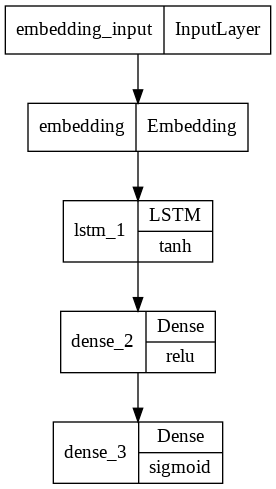

In [34]:
model.summary()
plot_model(model,show_layer_activations=True)

In [35]:
# @title Setting Hyper Parameters
num_epochs = 50
verbose = 1
shuffle = True
num_workers = 1

In [ ]:
# @title Training the model
history = model.fit(X_train, y_train,
                    epochs = num_epochs, validation_data = [X_test,y_test],
                    verbose = verbose,
                    shuffle=shuffle,
                    workers=num_workers)

In [37]:
# @title Model Evaluation on Test set
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 28s 3ms/step - loss: 0.5128 - accuracy: 0.8055


[0.5128017067909241, 0.8055375218391418]

In [55]:
# @title Model Sentient Analysis Function

def pred_sentient(text:str,verbose:bool = True)->float:
  seqeunce = tokenizer.texts_to_sequences([text])
  padding = pad_sequences(seqeunce, maxlen = 32, padding = 'post', truncating= 'post')
  prediction  = model.predict(padding)
  probablity = prediction[0][0]

  if verbose:
    if probablity > 0.5:
      print(f"With probablity of %{probablity:.2f} Positive Comemnt :\n{text}")
    else:
      probablity = 1 -  probablity
      print(f"With probablity of %{probablity:.2f} Negative Comemnt :\n{text}")


In [56]:
#@title Testing and Analysising the Sentient
text1 = 'I hate my life and you and everybody else, just kill me'
text2 = 'I love everything, I could not be happier'

pred_sentient(text1)
pred_sentient(text2)

1/1 [==============================] - 0s 17ms/step
With probablity of %0.97 Negative Comemnt :
I hate my life and you and everybody else, just kill me
1/1 [==============================] - 0s 17ms/step
With probablity of %0.99 Positive Comemnt :
I love everything, I could not be happier


# Using Pre-trained Embedding

In [ ]:
# @title Importing  libs, Downloading and Creating the Vocabulary
from  IPython.display import clear_output
import numpy as np

!apt-get install axel
!axel -n 16 http://nlp.stanford.edu/data/glove.6B.zip
!unzip -qx /content/glove.6B.zip
clear_output()


embedding_index = {}
f = open('/content/glove.6B.200d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:], dtype = 'float32')
  embedding_index[word] = coefs

In [ ]:
#Here we create a 300-dim 0 matrix for each word in vocab then we try to fill it with our ready to use vocab

embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i in range(vocab_size):
  word = index_word[i+1]
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
# @title Creating the LSTM Model
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim ,input_length= max_length, weights = [embedding_matrix],
                    trainable = False))
model.add(LSTM(64))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#Model Summary
model.summary()
plot_model(model)

In [ ]:
# @title Setting Hyperparameters
num_epochs = 50
verbose = 1
shuffle = True
num_workers = 1

In [ ]:
# @title Training the model
history = model.fit(X_train, y_train,
                    epochs = num_epochs, validation_data = [X_test,y_test],
                    verbose = verbose,
                    shuffle=shuffle,
                    workers=num_workers)

In [61]:
# @title Model Evaluation
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 40s 4ms/step - loss: 0.5128 - accuracy: 0.8055


[0.5128017067909241, 0.8055375218391418]

In [65]:
# @title Model Sentient Analysis Function

def pred_sentient(text:str,verbose:bool = True)->float:
  seqeunce = tokenizer.texts_to_sequences([text])
  padding = pad_sequences(seqeunce, maxlen = 32, padding = 'post', truncating= 'post')
  prediction  = model.predict(padding)
  probablity = prediction[0][0]

  if verbose:
    if probablity > 0.5:
      print(f"With probablity of %{probablity:.2f} Positive Comemnt :\n{text}")
    else:
      probablity = 1 -  probablity
      print(f"With probablity of %{probablity:.2f} Negative Comemnt :\n{text}")


In [68]:
#@title Testing and Analysising the Sentient
text1 = 'I hate my life and everybody,I will kill you all '
text2 = 'I love you,I want to merry you'

pred_sentient(text1)
pred_sentient(text2)

1/1 [==============================] - 0s 16ms/step
With probablity of %0.81 Negative Comemnt :
I hate my life and everybody,I will kill you all 
1/1 [==============================] - 0s 14ms/step
With probablity of %0.97 Positive Comemnt :
I love you,I want to merry you
